# 姓名生成模型训练 (LSTM + PyTorch)
本项目通过读取人名数据，使用字符级 LSTM 模型学习名字的生成结构，并实现自动补全功能。

In [5]:
# ✅ 1. 导入依赖
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os


## 📂 2. 读取并预处理姓名数据

In [6]:
# ... existing code ...

# 读取CSV文件
file_path = './all_names_combined.csv'  # 指定数据文件路径
df = pd.read_csv(file_path)  # 使用pandas读取CSV文件
print(df.head())  # 打印数据前5行，用于检查数据格式

# 处理姓名列，统一转为小写
names = df['Name'].unique()  # 获取姓名列的唯一值，去除重复
# 对每个姓名进行处理：
# 1. strip()去除首尾空格
# 2. lower()转换为小写
# 3. 只保留字符串类型的姓名
names = [name.strip().lower() for name in names if isinstance(name, str)]

# 构建字符集
all_text = ''.join(names)  # 将所有姓名连接成一个长字符串
chars = sorted(set(all_text))  # 获取所有不重复的字符并排序
# 创建字符到索引的映射字典
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
# 创建索引到字符的映射字典
idx_to_char = {idx: ch for ch, idx in char_to_idx.items()}
print(chars, len(chars))  # 打印字符集及其大小

# ... existing code ...

        Name Gender  Count   SourceFile
0       Mary      F   7065  yob1880.txt
1       Anna      F   2604  yob1880.txt
2       Emma      F   2003  yob1880.txt
3  Elizabeth      F   1939  yob1880.txt
4     Minnie      F   1746  yob1880.txt
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 26


## 🧩 3. 构造训练数据（序列输入 ➜ 下一个字符预测）

In [7]:
# 该段代码用于构建训练数据，将每个名字分解成多个序列样本
# 对于每个名字，我们取前n个字符作为输入序列，第n+1个字符作为预测目标
# 例如：对于名字"john"，会生成以下训练样本：
# 输入序列 -> 目标字符
# "j" -> "o"
# "jo" -> "h"
# "joh" -> "n"

# 设置最大序列长度为10
max_seq_len = 10
sequences, next_chars = [], []

# 遍历所有名字，生成训练序列
for name in names:
    for i in range(1, len(name)):
        seq = name[:i]  # 取名字的前i个字符作为输入序列
        next_char = name[i]  # 取第i+1个字符作为预测目标
        if len(seq) <= max_seq_len:  # 只保留长度不超过max_seq_len的序列
            sequences.append(seq)
            next_chars.append(next_char)

# 创建输入特征矩阵X和标签向量y
X = np.zeros((len(sequences), max_seq_len), dtype=np.int32)  # 初始化输入矩阵，用0填充
y = np.zeros(len(sequences), dtype=np.int32)  # 初始化标签向量

# 将字符序列转换为数字索引
for i, seq in enumerate(sequences):
    # 将序列填充到max_seq_len长度，短序列从右侧开始填充
    for t, char in enumerate(seq):
        X[i, max_seq_len - len(seq) + t] = char_to_idx[char]
    # 将目标字符转换为对应的索引
    y[i] = char_to_idx[next_chars[i]]

print(X.shape, y.shape)  # 打印数据形状，用于检查

(577963, 10) (577963,)


## 🧠 4. 定义 LSTM 模型结构
这段代码实现了一个用于姓名生成的LSTM模型。模型的主要特点是：<br>
使用字符级别的嵌入层，将每个字符转换为32维的向量表示<br>
使用LSTM层处理序列信息，隐藏层维度为128<br>
最后通过全连接层输出下一个字符的概率分布<br>
模型采用批处理方式（batch_first=True），便于处理多个样本<br>

In [11]:
# 这段代码定义了一个基于LSTM的姓名预测模型
# 模型结构：字符嵌入层 -> LSTM层 -> 全连接层
# 输入：字符序列，输出：下一个字符的概率分布

class NamePredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout=0.2):
        super(NamePredictor, self).__init__()
        # 字符嵌入层：将每个字符转换为embedding_dim维的向量表示
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM层：处理序列信息，hidden_dim为隐藏状态维度
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Dropout层：防止过拟合，默认丢弃率为0.2
        self.dropout = nn.Dropout(dropout)
        # 全连接层：将LSTM的输出映射到词汇表大小的概率分布
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        # 1. 字符嵌入：将输入序列转换为向量表示
        embedded = self.embedding(x)
        # 2. LSTM处理：获取序列的隐藏状态
        _, (h_n, _) = self.lstm(embedded)
        # 3. 应用dropout并去除多余的维度
        h_n = self.dropout(h_n.squeeze(0))
        # 4. 通过全连接层得到最终输出
        output = self.fc(h_n)
        return output

# 创建模型实例
vocab_size = len(char_to_idx)  # 词汇表大小（字符集大小）
model = NamePredictor(vocab_size, embedding_dim=32, hidden_dim=128)  # 创建模型实例
print(model)  # 打印模型结构

NamePredictor(
  (embedding): Embedding(26, 32)
  (lstm): LSTM(32, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=26, bias=True)
)


## 🏋️‍♂️ 5. 模型训练（保存最优模型 + 显示进度）

In [13]:
# 这段代码实现了LSTM模型的训练过程，主要功能包括：
# 1. 数据准备：将数据转换为PyTorch张量并创建数据加载器
# 2. 训练循环：使用Adam优化器进行模型训练
# 3. 模型保存：保存训练过程中损失最低的模型
# 4. 进度显示：使用tqdm显示训练进度和损失值

# 设置设备（GPU/CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 检查是否有GPU可用，如果有则使用GPU，否则使用CPU
model = model.to(device)  # 将模型移动到指定设备上

# 将数据转换为PyTorch张量并创建数据加载器
X_tensor = torch.tensor(X, dtype=torch.long)  # 将输入数据转换为PyTorch长整型张量
y_tensor = torch.tensor(y, dtype=torch.long)  # 将标签数据转换为PyTorch长整型张量
dataset = TensorDataset(X_tensor, y_tensor)  # 创建数据集对象
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)  # 创建数据加载器，设置批量大小为512，并随机打乱数据

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数，适用于多分类问题
optimizer = optim.Adam(model.parameters(), lr=0.005)  # 使用Adam优化器，设置学习率为0.005

# 初始化训练相关变量
best_loss = float('inf')  # 初始化最佳损失值为无穷大
save_path = 'best_name_model.pt'  # 设置模型保存路径
epoch_losses = []  # 创建列表用于记录每个epoch的平均损失

# 开始训练循环
num_epochs = 50  # 设置训练轮数为50
for epoch in range(1, num_epochs + 1):
    model.train()  # 将模型设置为训练模式
    epoch_loss = 0  # 初始化当前epoch的总损失
    total_samples = 0  # 初始化当前epoch的总样本数
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs}")  # 创建进度条，显示当前训练进度
    
    # 遍历每个批次
    for batch_x, batch_y in pbar:
        # 将数据移到指定设备
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 将批次数据移动到指定设备（GPU/CPU）
        optimizer.zero_grad()  # 清空之前的梯度
        outputs = model(batch_x)  # 前向传播，获取模型预测结果
        loss = criterion(outputs, batch_y)  # 计算损失值
        loss.backward()  # 反向传播，计算梯度
        optimizer.step()  # 更新模型参数
        
        # 累计损失和样本数
        batch_size = batch_x.size(0)  # 获取当前批次的大小
        epoch_loss += loss.item() * batch_size  # 累加批次损失
        total_samples += batch_size  # 累加样本数
        pbar.set_postfix({"BatchLoss": f"{loss.item():.4f}"})  # 在进度条中显示当前批次的损失值
    
    # 计算并记录平均损失
    avg_loss = epoch_loss / total_samples  # 计算当前epoch的平均损失
    epoch_losses.append(avg_loss)  # 将平均损失添加到记录列表中

    # 如果当前epoch的损失更低，保存模型
    if avg_loss < best_loss:
        best_loss = avg_loss  # 更新最佳损失值
        torch.save(model.state_dict(), save_path)  # 保存模型参数
        print(f"✅ Model saved. New best loss: {best_loss:.6f}")  # 打印保存信息

    print(f"Epoch {epoch}, Avg Loss: {avg_loss:.6f}")  # 打印当前epoch的平均损失

Epoch 1/50: 100%|██████████| 1129/1129 [00:08<00:00, 129.51it/s, BatchLoss=2.0775]


✅ Model saved. New best loss: 2.164813
Epoch 1, Avg Loss: 2.164813


Epoch 2/50: 100%|██████████| 1129/1129 [00:07<00:00, 148.05it/s, BatchLoss=2.0683]


✅ Model saved. New best loss: 2.055773
Epoch 2, Avg Loss: 2.055773


Epoch 3/50: 100%|██████████| 1129/1129 [00:07<00:00, 147.58it/s, BatchLoss=2.0683]


✅ Model saved. New best loss: 2.022362
Epoch 3, Avg Loss: 2.022362


Epoch 4/50: 100%|██████████| 1129/1129 [00:07<00:00, 145.30it/s, BatchLoss=2.0833]


✅ Model saved. New best loss: 2.003840
Epoch 4, Avg Loss: 2.003840


Epoch 5/50: 100%|██████████| 1129/1129 [00:07<00:00, 143.87it/s, BatchLoss=1.9159]


✅ Model saved. New best loss: 1.990924
Epoch 5, Avg Loss: 1.990924


Epoch 6/50: 100%|██████████| 1129/1129 [00:07<00:00, 149.72it/s, BatchLoss=1.9681]


✅ Model saved. New best loss: 1.980656
Epoch 6, Avg Loss: 1.980656


Epoch 7/50: 100%|██████████| 1129/1129 [00:07<00:00, 144.27it/s, BatchLoss=2.0705]


✅ Model saved. New best loss: 1.972777
Epoch 7, Avg Loss: 1.972777


Epoch 8/50: 100%|██████████| 1129/1129 [00:08<00:00, 139.68it/s, BatchLoss=1.9562]


✅ Model saved. New best loss: 1.966615
Epoch 8, Avg Loss: 1.966615


Epoch 9/50: 100%|██████████| 1129/1129 [00:08<00:00, 139.03it/s, BatchLoss=2.1055]


✅ Model saved. New best loss: 1.962415
Epoch 9, Avg Loss: 1.962415


Epoch 10/50: 100%|██████████| 1129/1129 [00:08<00:00, 131.68it/s, BatchLoss=1.8987]


✅ Model saved. New best loss: 1.957564
Epoch 10, Avg Loss: 1.957564


Epoch 11/50: 100%|██████████| 1129/1129 [00:07<00:00, 141.99it/s, BatchLoss=2.0759]


✅ Model saved. New best loss: 1.954346
Epoch 11, Avg Loss: 1.954346


Epoch 12/50: 100%|██████████| 1129/1129 [00:07<00:00, 144.53it/s, BatchLoss=1.9472]


✅ Model saved. New best loss: 1.951254
Epoch 12, Avg Loss: 1.951254


Epoch 13/50: 100%|██████████| 1129/1129 [00:08<00:00, 139.68it/s, BatchLoss=1.8920]


✅ Model saved. New best loss: 1.947706
Epoch 13, Avg Loss: 1.947706


Epoch 14/50: 100%|██████████| 1129/1129 [00:08<00:00, 140.48it/s, BatchLoss=1.9720]


✅ Model saved. New best loss: 1.946375
Epoch 14, Avg Loss: 1.946375


Epoch 15/50: 100%|██████████| 1129/1129 [00:07<00:00, 148.50it/s, BatchLoss=1.9431]


✅ Model saved. New best loss: 1.943972
Epoch 15, Avg Loss: 1.943972


Epoch 16/50: 100%|██████████| 1129/1129 [00:07<00:00, 144.40it/s, BatchLoss=2.0008]


✅ Model saved. New best loss: 1.941850
Epoch 16, Avg Loss: 1.941850


Epoch 17/50: 100%|██████████| 1129/1129 [00:08<00:00, 135.69it/s, BatchLoss=1.9576]


✅ Model saved. New best loss: 1.940360
Epoch 17, Avg Loss: 1.940360


Epoch 18/50: 100%|██████████| 1129/1129 [00:07<00:00, 146.07it/s, BatchLoss=1.9414]


✅ Model saved. New best loss: 1.938169
Epoch 18, Avg Loss: 1.938169


Epoch 19/50: 100%|██████████| 1129/1129 [00:07<00:00, 143.19it/s, BatchLoss=1.9601]


✅ Model saved. New best loss: 1.936895
Epoch 19, Avg Loss: 1.936895


Epoch 20/50: 100%|██████████| 1129/1129 [00:07<00:00, 144.69it/s, BatchLoss=2.0036]


✅ Model saved. New best loss: 1.935749
Epoch 20, Avg Loss: 1.935749


Epoch 21/50: 100%|██████████| 1129/1129 [00:07<00:00, 143.71it/s, BatchLoss=1.9218]


✅ Model saved. New best loss: 1.933950
Epoch 21, Avg Loss: 1.933950


Epoch 22/50: 100%|██████████| 1129/1129 [00:07<00:00, 143.66it/s, BatchLoss=1.8569]


✅ Model saved. New best loss: 1.933396
Epoch 22, Avg Loss: 1.933396


Epoch 23/50: 100%|██████████| 1129/1129 [00:07<00:00, 146.04it/s, BatchLoss=1.9921]


✅ Model saved. New best loss: 1.932187
Epoch 23, Avg Loss: 1.932187


Epoch 24/50: 100%|██████████| 1129/1129 [00:07<00:00, 145.79it/s, BatchLoss=1.9284]


✅ Model saved. New best loss: 1.931886
Epoch 24, Avg Loss: 1.931886


Epoch 25/50: 100%|██████████| 1129/1129 [00:08<00:00, 130.42it/s, BatchLoss=1.8818]


✅ Model saved. New best loss: 1.930535
Epoch 25, Avg Loss: 1.930535


Epoch 26/50: 100%|██████████| 1129/1129 [00:07<00:00, 147.63it/s, BatchLoss=1.8401]


Epoch 26, Avg Loss: 1.930715


Epoch 27/50: 100%|██████████| 1129/1129 [00:08<00:00, 140.45it/s, BatchLoss=2.1231]


✅ Model saved. New best loss: 1.929486
Epoch 27, Avg Loss: 1.929486


Epoch 28/50: 100%|██████████| 1129/1129 [00:07<00:00, 141.37it/s, BatchLoss=1.9969]


✅ Model saved. New best loss: 1.929291
Epoch 28, Avg Loss: 1.929291


Epoch 29/50: 100%|██████████| 1129/1129 [00:08<00:00, 140.74it/s, BatchLoss=1.9115]


✅ Model saved. New best loss: 1.928422
Epoch 29, Avg Loss: 1.928422


Epoch 30/50: 100%|██████████| 1129/1129 [00:07<00:00, 146.94it/s, BatchLoss=2.0130]


✅ Model saved. New best loss: 1.927696
Epoch 30, Avg Loss: 1.927696


Epoch 31/50: 100%|██████████| 1129/1129 [00:08<00:00, 135.24it/s, BatchLoss=1.8099]


Epoch 31, Avg Loss: 1.927784


Epoch 32/50: 100%|██████████| 1129/1129 [00:07<00:00, 143.31it/s, BatchLoss=1.8688]


✅ Model saved. New best loss: 1.927231
Epoch 32, Avg Loss: 1.927231


Epoch 33/50: 100%|██████████| 1129/1129 [00:08<00:00, 136.49it/s, BatchLoss=1.8597]


✅ Model saved. New best loss: 1.927073
Epoch 33, Avg Loss: 1.927073


Epoch 34/50: 100%|██████████| 1129/1129 [00:08<00:00, 140.02it/s, BatchLoss=1.8989]


✅ Model saved. New best loss: 1.926042
Epoch 34, Avg Loss: 1.926042


Epoch 35/50: 100%|██████████| 1129/1129 [00:07<00:00, 147.32it/s, BatchLoss=1.9489]


✅ Model saved. New best loss: 1.925438
Epoch 35, Avg Loss: 1.925438


Epoch 36/50: 100%|██████████| 1129/1129 [00:08<00:00, 128.32it/s, BatchLoss=1.9831]


Epoch 36, Avg Loss: 1.925875


Epoch 37/50: 100%|██████████| 1129/1129 [00:09<00:00, 116.35it/s, BatchLoss=1.9587]


Epoch 37, Avg Loss: 1.925836


Epoch 38/50: 100%|██████████| 1129/1129 [00:08<00:00, 129.73it/s, BatchLoss=1.8986]


Epoch 38, Avg Loss: 1.925968


Epoch 39/50: 100%|██████████| 1129/1129 [00:08<00:00, 129.99it/s, BatchLoss=1.8895]


✅ Model saved. New best loss: 1.925222
Epoch 39, Avg Loss: 1.925222


Epoch 40/50: 100%|██████████| 1129/1129 [00:08<00:00, 127.79it/s, BatchLoss=1.9508]


✅ Model saved. New best loss: 1.924644
Epoch 40, Avg Loss: 1.924644


Epoch 41/50: 100%|██████████| 1129/1129 [00:08<00:00, 133.13it/s, BatchLoss=1.9912]


Epoch 41, Avg Loss: 1.924895


Epoch 42/50: 100%|██████████| 1129/1129 [00:08<00:00, 139.71it/s, BatchLoss=2.0160]


✅ Model saved. New best loss: 1.924554
Epoch 42, Avg Loss: 1.924554


Epoch 43/50: 100%|██████████| 1129/1129 [00:08<00:00, 133.19it/s, BatchLoss=1.8518]


✅ Model saved. New best loss: 1.924542
Epoch 43, Avg Loss: 1.924542


Epoch 44/50: 100%|██████████| 1129/1129 [00:09<00:00, 119.29it/s, BatchLoss=2.0207]


✅ Model saved. New best loss: 1.924248
Epoch 44, Avg Loss: 1.924248


Epoch 45/50: 100%|██████████| 1129/1129 [00:09<00:00, 118.45it/s, BatchLoss=1.9798]


✅ Model saved. New best loss: 1.923905
Epoch 45, Avg Loss: 1.923905


Epoch 46/50: 100%|██████████| 1129/1129 [00:10<00:00, 108.05it/s, BatchLoss=1.9441]


Epoch 46, Avg Loss: 1.924318


Epoch 47/50: 100%|██████████| 1129/1129 [00:08<00:00, 127.30it/s, BatchLoss=1.9278]


Epoch 47, Avg Loss: 1.924769


Epoch 48/50: 100%|██████████| 1129/1129 [00:10<00:00, 109.56it/s, BatchLoss=1.8895]


Epoch 48, Avg Loss: 1.924532


Epoch 49/50: 100%|██████████| 1129/1129 [00:08<00:00, 133.13it/s, BatchLoss=2.0009]


Epoch 49, Avg Loss: 1.925926


Epoch 50/50: 100%|██████████| 1129/1129 [00:09<00:00, 122.35it/s, BatchLoss=1.9253]

Epoch 50, Avg Loss: 1.926072


🔍 当前瓶颈可能来自以下几方面：
```
1. 模型容量不足（常见）
当前模型参数较少：embedding_dim = 32，hidden_dim = 128
2. 模型结构过于简单
单层 LSTM，非双向，没有 dropout 或 residual

每次预测只使用最后一层的隐藏状态（h_n）
3. 输入未加权（不考虑频率）
当前所有名字视为等权，未利用 Count 列作为训练样本权重或数据增强
```

对大数据量的名字来说表达能力有限
✅ 建议你下一步尝试的调整组合：
```python
embedding_dim = 128
hidden_dim = 256
num_layers = 2
bidirectional = True
Dropout = 0.3
```

## 📉 6. 绘制训练过程 Loss 曲线

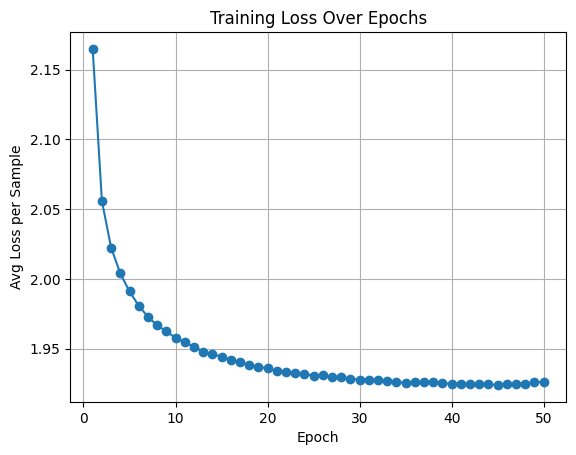

In [14]:
# 这段代码用于可视化模型训练过程中的损失变化
# 通过绘制损失曲线，我们可以：
# 1. 观察模型是否正常收敛
# 2. 判断是否需要调整学习率或训练轮数
# 3. 评估模型的训练效果

# 绘制训练损失曲线
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')  # 使用圆点标记每个数据点
plt.title('Training Loss Over Epochs')  # 设置图表标题
plt.xlabel('Epoch')  # 设置x轴标签
plt.ylabel('Avg Loss per Sample')  # 设置y轴标签
plt.grid(True)  # 显示网格线，便于读取数值
plt.show()  # 显示图表

## 🔮 7. 姓名补全预测函数 + 测试

In [15]:
# 这段代码实现了一个基于LSTM模型的姓名补全功能
# 主要功能：
# 1. 接收用户输入的名字前缀
# 2. 使用训练好的LSTM模型预测后续字符
# 3. 当遇到特定结束字符或达到最大长度时停止生成
# 4. 返回完整的生成名字

def predict_name(prefix, max_len=20):
    model.eval()  # 将模型设置为评估模式
    prefix = prefix.lower()  # 将输入前缀转换为小写
    generated = prefix  # 初始化生成的名字
    # 将输入前缀中的每个字符转换为对应的索引
    input_seq = [char_to_idx.get(ch, 0) for ch in prefix]

    # 循环生成后续字符，直到达到最大长度
    for _ in range(max_len - len(prefix)):
        # 创建输入张量，初始化为全0
        x = torch.zeros((1, max_seq_len), dtype=torch.long).to(device)
        # 将输入序列填充到张量中，从右侧开始填充
        x[0, -len(input_seq):] = torch.tensor(input_seq[-max_seq_len:], dtype=torch.long).to(device)

        # 使用模型进行预测
        with torch.no_grad():  # 不计算梯度
            output = model(x)  # 获取模型输出
            probs = torch.softmax(output, dim=1).squeeze()  # 将输出转换为概率分布
            next_char_idx = torch.argmax(probs).item()  # 选择概率最高的字符索引

        # 将预测的字符添加到生成的名字中
        next_char = idx_to_char[next_char_idx]
        generated += next_char
        input_seq.append(next_char_idx)

        # 如果遇到特定结束字符且名字长度大于4，则停止生成
        if next_char in ['n', 'y', 'e'] and len(generated) > 4:
            break
    return generated

# 测试不同前缀的补全效果
test_prefixes = ['j', 'a', 'mi', 'li', 'el', 'ch']
for prefix in test_prefixes:
    print(f"{prefix} ➜ {predict_name(prefix)}")

j ➜ janay
a ➜ alatan
mi ➜ millian
li ➜ lillian
el ➜ elizabe
ch ➜ charle
